# Module 3: Simulating Absorbance Spectra with HITRAN

---

In this module, we'll use the HITRAN spectroscopic database to generate realistic methane absorbance spectra.

**Learning Objectives:**
- Understand what HITRAN is and some practical limits to its usefulness
- Install and use the HAPI (HITRAN API) Python library
- Generate absorbance spectra for CH₄ at various conditions
- Explore how T, P, and $\chi$ affect the spectrum

**Deliverable:** A working function that generates absorbance spectra for any (T, P, $\chi$) input.

---
## 3.1 — Introduction to HITRAN and HAPI

### What is HITRAN?

**HITRAN** (High-Resolution Transmission Molecular Absorption Database) is the international standard for molecular spectroscopic data. It contains:

- **Line positions** — exactly where each absorption transition occurs
- **Line intensities** — how strong each transition is
- **Broadening parameters** — how pressure and temperature affect line shapes
- **Energy levels** — for calculating temperature dependence

For our CH₄ detection, HITRAN tells us precisely where methane absorbs light and how strongly.

**Website:** https://hitran.org

### What is HAPI?

**HAPI** (HITRAN Application Programming Interface) is the official Python library for working with HITRAN data. It provides:

- `fetch()` — Download line parameters from HITRAN
- `absorptionCoefficient_Voigt()` — Calculate absorption coefficients with proper line shapes
- Various other spectral calculation functions

Let's install it!

In [1]:
# Install HAPI
!pip install hitran-api --quiet

print("✅ HAPI installed!")


,[notice] A new release of pip is available: 25.3 -> 26.0.1
,[notice] To update, run: pip install --upgrade pip
,✅ HAPI installed!


In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Import HAPI
import hapi

# Set up plotting defaults
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 11

print(f"HAPI version: {hapi.__version__ if hasattr(hapi, '__version__') else 'installed'}")
print("✅ All imports successful!")

HAPI version: 1.3.0.0
,To get the most up-to-date version please check http://hitran.org/hapi
,ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code
,
,           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 
,
,           If you use HAPI in your research or software development,
,           please cite it using the following reference:
,           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
,           HITRAN Application Programming Interface (HAPI): A comprehensive approach
,           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
,           DOI: 10.1016/j.jqsrt.2016.03.005
,
,           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
,                      For more efficient implementation of the absorption coefficient routine, 
,                      as well as for new profiles, parameters and other fun

### Setting Up the HITRAN Data Directory

HAPI stores downloaded spectral data locally. We'll create a dedicated directory for this.

In [3]:
# Create directory for HITRAN data
PROJECT_DIR = Path.home() / 'methane-ml-course'
HITRAN_DATA_DIR = PROJECT_DIR / 'data' / 'hitran'
HITRAN_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Tell HAPI where to store data
hapi.db_begin(str(HITRAN_DATA_DIR))

print(f"HITRAN data directory: {HITRAN_DATA_DIR}")
print("✅ Database initialized!")

Using /root/methane-ml-course/data/hitran
,
,HITRAN data directory: /root/methane-ml-course/data/hitran
,✅ Database initialized!


### HITRAN Molecule and Isotopologue IDs

HITRAN uses numeric IDs for molecules. For methane:

| Molecule | ID | Main Isotopologue ID |
|----------|----|-----------------------|
| CH₄      | 6  | 1 (¹²CH₄)            |

Other common molecules:
- H₂O = 1
- CO₂ = 2
- O₃ = 3
- CO = 5
- CH₄ = 6

### HITRAN Parameters

HITRAN data for each lin-transition in your frequency range is provided. Every line of the database has a series of parameters for a given line transition. Some of the parameters included are molecule number, isotopologue ID, wavenumber, line intensity, Einstein A coefficient, and broadening coefficients (air + self). You can visit the HITRAN site (https://hitran.org/docs/definitions-and-units/) for a list of the parameters included in each line of the data that gets downloaded.

In [6]:
# Define our target molecule
MOLECULE_ID = 6      # CH4
ISOTOPE_ID = 1       # Main isotopologue (12CH4)
MOLECULE_NAME = 'CH4'

# Our wavenumber range of interest
NU_MIN = 4382.0  # cm⁻¹
NU_MAX = 4386.0  # cm⁻¹

print(f"Target: {MOLECULE_NAME} (ID={MOLECULE_ID}, Isotope={ISOTOPE_ID})")
print(f"Wavenumber range: {NU_MIN} - {NU_MAX} cm⁻¹")
print(f"Wavelength range: {1e7/NU_MAX:.2f} - {1e7/NU_MIN:.2f} nm")

Target: CH4 (ID=6, Isotope=1)
,Wavenumber range: 4382.0 - 4386.0 cm⁻¹
,Wavelength range: 2279.98 - 2282.06 nm


---
## 3.2 — Fetching HITRAN Line Data

Now let's download the CH₄ line parameters for our wavenumber range.

In [7]:
# Fetch CH4 data from HITRAN
# This downloads from the internet on first run, then uses cached data

TABLE_NAME = 'CH4_4383_4386'

print(f"Fetching {MOLECULE_NAME} data from HITRAN...")
print(f"Wavenumber range: {NU_MIN} - {NU_MAX} cm⁻¹")
print("(This may take a moment on first run)\n")

try:
    hapi.fetch(
        TableName=TABLE_NAME,
        M=MOLECULE_ID,
        I=ISOTOPE_ID,
        numin=NU_MIN,
        numax=NU_MAX
    )
    print("✅ Data fetched successfully!")
except Exception as e:
    print(f"Note: {e}")
    print("Data may already be cached locally.")

Fetching CH4 data from HITRAN...
,Wavenumber range: 4382.0 - 4386.0 cm⁻¹
,(This may take a moment on first run)
,
,
,Data is fetched from http://hitran.org
,
,BEGIN DOWNLOAD: CH4_4383_4386
,  65536 bytes written to /root/methane-ml-course/data/hitran/CH4_4383_4386.data
,  65536 bytes written to /root/methane-ml-course/data/hitran/CH4_4383_4386.data
,Header written to /root/methane-ml-course/data/hitran/CH4_4383_4386.header
,END DOWNLOAD
,                     Lines parsed: 501
,PROCESSED
,✅ Data fetched successfully!


In [8]:
# Check what data we have
print("Tables in database:")
hapi.tableList()

Tables in database:


dict_keys(['sampletab', 'CH4_4383_4386'])

In [12]:
# Get information about the downloaded data
print(f"\nLine data for {TABLE_NAME}:")
print("-" * 50)

# Get line positions and intensities (HAPI returns just the array)
nu_lines = hapi.getColumn(TABLE_NAME, 'nu')
sw_lines = hapi.getColumn(TABLE_NAME, 'sw')  # Line intensity

# print(f"Number of spectral lines: {len(nu_lines)}")
# print(f"\nLine positions (cm⁻¹):")
# for i, (nu, sw) in enumerate(zip(nu_lines, sw_lines)):
#     print(f"  Line {i+1}: ν = {nu:.4f} cm⁻¹, Intensity = {sw:.2e} cm/molecule")

# print(f"\nThese are the CH₄ absorption lines we'll use for detection!")


,Line data for CH4_4383_4386:
,--------------------------------------------------


### Understanding Line Intensities

The line intensities for the three prominent transitions in this wavenumber ranve vary by about an order of magnitude. This is intentional for our sensor design:
- **Strongest line** → Best sensitivity at low concentrations
- **Weakest line** → Provides sensor sensitivity at high concentrations

The CNN will learn to use the appropriate line(s) based on the concentration.

---
## 3.3 — Generating a Single Absorbance Spectrum

Now we'll compute the absorption coefficient and absorbance for a specific set of conditions.

### The Voigt Line Shape

Real lineshape is determined by many factors. The overwhelming broadening mechanisms for atmospheric methane lineshape are:

1. **Doppler broadening** (Gaussian) — from molecular thermal motion, depends on T
2. **Pressure broadening** (Lorentzian) — from molecular collisions, depends on P

The combination is a **Voigt profile** — a convolution of Gaussian and Lorentzian shapes. A much deeper account of broadening mechanisms can be found in Spectroscopy and Optical Diagnostics for Gases by Hanson, Spearrin, and Goldenstein, 2016.

HAPI handles all of this automatically with `absorptionCoefficient_Voigt()`!

In [13]:
def generate_absorbance_spectrum(T, P, xi, L=100, nu_min=4383, nu_max=4386, nu_step=0.001):
    """
    Generate an absorbance spectrum for CH4.
    
    Parameters:
    -----------
    T : float
        Temperature in Kelvin
    P : float  
        Pressure in atmospheres
    xi : float
        Mole fraction (e.g., 0.01 = 10,000 ppm)
    L : float
        Path length in cm (default 100)
    nu_min, nu_max : float
        Wavenumber range in cm⁻¹
    nu_step : float
        Wavenumber step size in cm⁻¹
        
    Returns:
    --------
    nu : numpy array
        Wavenumber grid (cm⁻¹)
    absorbance : numpy array
        Absorbance values (dimensionless)
    """
    
    # Calculate absorption coefficient using HAPI
    # This uses the Voigt line shape with proper T and P dependence
    nu, coef = hapi.absorptionCoefficient_Voigt(
        SourceTables=TABLE_NAME,
        Components=[(MOLECULE_ID, ISOTOPE_ID, xi)],  # (molecule, isotope, mole_fraction)
        Environment={'T': T, 'p': P},  # T in K, P in atm
        WavenumberRange=[nu_min, nu_max],
        WavenumberStep=nu_step,
        HITRAN_units=False  # Use cm⁻¹ for output
    )
    
    # Convert absorption coefficient to absorbance
    # α = k * L (the mole fraction is already included in coef)
    absorbance = coef * L
    
    return nu, absorbance

In [14]:
# Generate a spectrum at standard conditions
T = 296  # K (23°C, HITRAN reference temperature)
P = 1.0  # atm
xi = 0.01  # 10,000 ppm (1%)
L = 100  # cm path length

print(f"Generating spectrum for:")
print(f"  Temperature: {T} K ({T-273:.1f}°C)")
print(f"  Pressure: {P} atm")
print(f"  Mole fraction: {xi} ({xi*1e6:.0f} ppm)")
print(f"  Path length: {L} cm")
print()

nu, absorbance = generate_absorbance_spectrum(T, P, xi, L)

print(f"✅ Generated spectrum with {len(nu)} points")
print(f"   Wavenumber range: {nu.min():.3f} - {nu.max():.3f} cm⁻¹")
print(f"   Peak absorbance: {absorbance.max():.4f}")

Generating spectrum for:
,  Temperature: 296 K (23.0°C)
,  Pressure: 1.0 atm
,  Mole fraction: 0.01 (10000 ppm)
,  Path length: 100 cm
,
,{'air': 1.0}
,0.164841 seconds elapsed for abscoef; nlines = 501
,✅ Generated spectrum with 3001 points
,   Wavenumber range: 4383.000 - 4386.000 cm⁻¹
,   Peak absorbance: 0.6911


In [1]:
# Plot the spectrum
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(nu, absorbance, 'b-', linewidth=1)
ax.set_xlabel('Wavenumber (cm⁻¹)')
ax.set_ylabel('Absorbance α')
ax.set_title(f'CH₄ Absorbance Spectrum\nT={T}K, P={P}atm, $\\chi$={xi*1e6:.0f}ppm, L={L}cm')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<class 'NameError'>: name 'plt' is not defined

### Understanding the Output

Notice the three distinct absorption peaks:
1. **Strongest peak** — Most sensitive but saturates at high concentrations
2. **Medium peak** — Good for mid-range concentrations  
3. **Weakest peak** — Stays linear even at high concentrations

The CNN will learn to use information from all three lines appropriately!

---
## 3.4 — Exploring Parameter Sensitivity

Let's see how the spectrum changes with T, P, and $\chi$.

### Effect of Mole Fraction (Concentration)

{'air': 1.0}
,0.171473 seconds elapsed for abscoef; nlines = 501
,{'air': 1.0}
,0.165266 seconds elapsed for abscoef; nlines = 501
,{'air': 1.0}
,0.157732 seconds elapsed for abscoef; nlines = 501
,{'air': 1.0}
,0.158861 seconds elapsed for abscoef; nlines = 501
,{'air': 1.0}
,0.157766 seconds elapsed for abscoef; nlines = 501


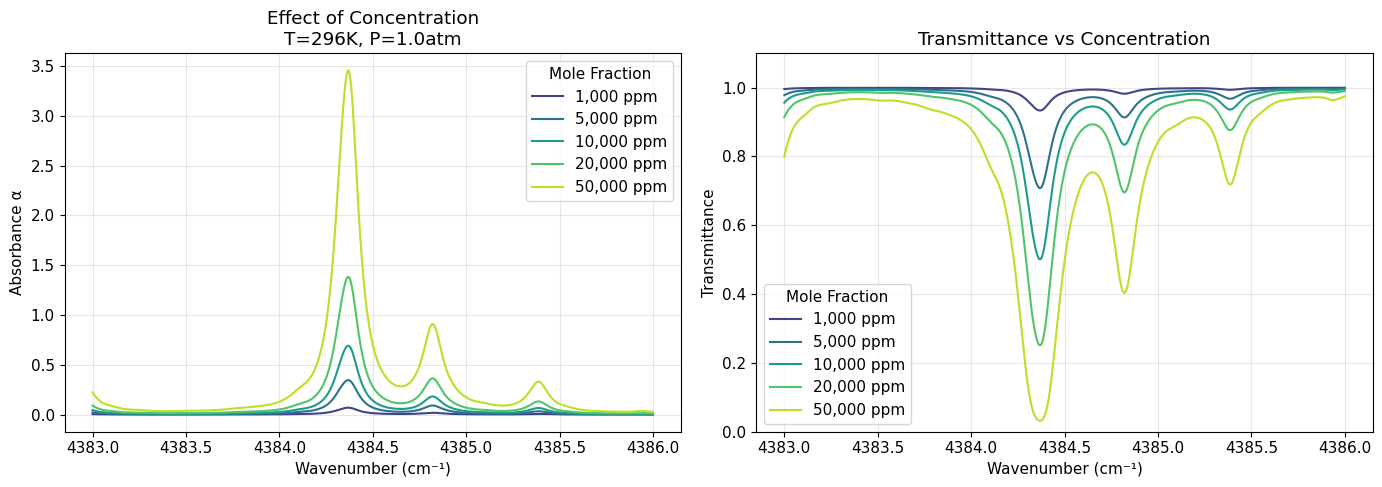

In [23]:
# Vary mole fraction
T_fixed = 296  # K
P_fixed = 1.0  # atm
L = 100  # cm

xi_values = [0.001, 0.005, 0.01, 0.02, 0.05]  # 1000 to 50000 ppm
xi_labels = ['1,000 ppm', '5,000 ppm', '10,000 ppm', '20,000 ppm', '50,000 ppm']
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(xi_values)))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for xi, label, color in zip(xi_values, xi_labels, colors):
    nu, absorbance = generate_absorbance_spectrum(T_fixed, P_fixed, xi, L)
    transmittance = np.exp(-absorbance)
    
    axes[0].plot(nu, absorbance, color=color, linewidth=1.5, label=label)
    axes[1].plot(nu, transmittance, color=color, linewidth=1.5, label=label)

axes[0].set_xlabel('Wavenumber (cm⁻¹)')
axes[0].set_ylabel('Absorbance α')
axes[0].set_title(f'Effect of Concentration\nT={T_fixed}K, P={P_fixed}atm')
axes[0].legend(title='Mole Fraction')
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Wavenumber (cm⁻¹)')
axes[1].set_ylabel('Transmittance')
axes[1].set_title('Transmittance vs Concentration')
axes[1].legend(title='Mole Fraction')
axes[1].set_ylim(0, 1.1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Effect of Temperature

{'air': 1.0}
,0.173356 seconds elapsed for abscoef; nlines = 501
,{'air': 1.0}
,0.177433 seconds elapsed for abscoef; nlines = 501
,{'air': 1.0}
,0.164714 seconds elapsed for abscoef; nlines = 501
,{'air': 1.0}
,0.156224 seconds elapsed for abscoef; nlines = 501
,{'air': 1.0}
,0.155319 seconds elapsed for abscoef; nlines = 501


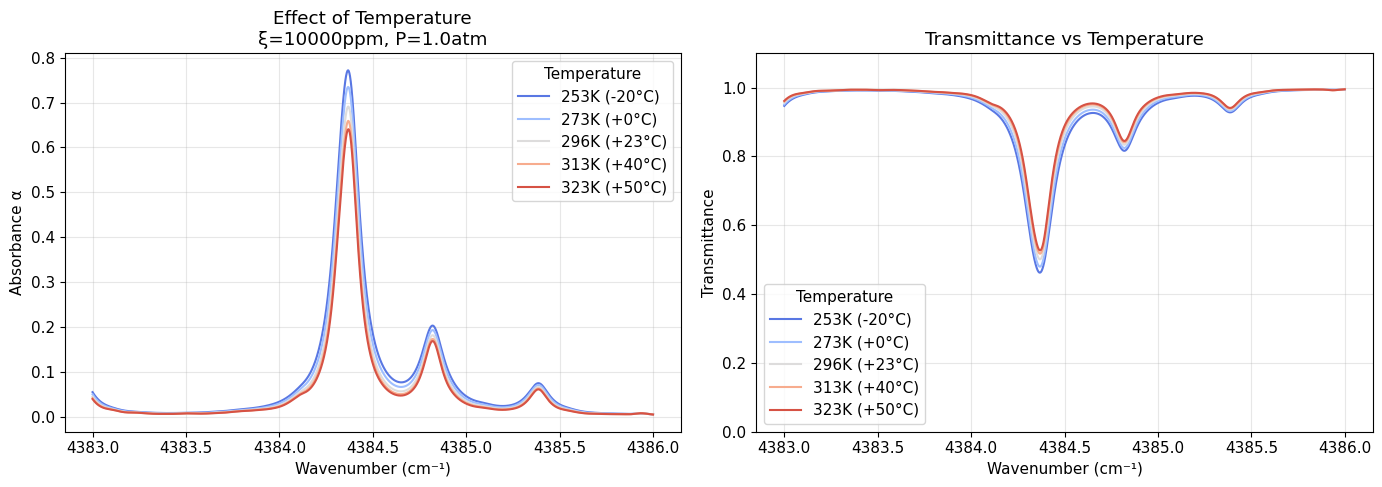

Key observations:
,• Line STRENGTH changes with temperature (partition function effect)
,• Line WIDTH changes slightly (Doppler broadening depends on T)
,• This is why the CNN needs to know about temperature.


In [25]:
# Vary temperature
xi_fixed = 0.01  # 10,000 ppm
P_fixed = 1.0  # atm
L = 100  # cm

T_values = [253, 273, 296, 313, 323]  # K
T_labels = [f'{T}K ({T-273:+.0f}°C)' for T in T_values]
colors = plt.cm.coolwarm(np.linspace(0.1, 0.9, len(T_values)))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for T, label, color in zip(T_values, T_labels, colors):
    nu, absorbance = generate_absorbance_spectrum(T, P_fixed, xi_fixed, L)
    transmittance = np.exp(-absorbance)
    
    axes[0].plot(nu, absorbance, color=color, linewidth=1.5, label=label)
    axes[1].plot(nu, transmittance, color=color, linewidth=1.5, label=label)

axes[0].set_xlabel('Wavenumber (cm⁻¹)')
axes[0].set_ylabel('Absorbance α')
axes[0].set_title(f'Effect of Temperature\nξ={xi_fixed*1e6:.0f}ppm, P={P_fixed}atm')
axes[0].legend(title='Temperature')
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Wavenumber (cm⁻¹)')
axes[1].set_ylabel('Transmittance')
axes[1].set_title('Transmittance vs Temperature')
axes[1].legend(title='Temperature')
axes[1].set_ylim(0, 1.1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key observations:")
print("• Line STRENGTH changes with temperature (partition function effect)")
print("• Line WIDTH changes slightly (Doppler broadening depends on T)")
print("• This is why the CNN needs to know about temperature.")

### Effect of Pressure

{'air': 1.0}
,0.149600 seconds elapsed for abscoef; nlines = 501
,{'air': 1.0}
,0.159813 seconds elapsed for abscoef; nlines = 501
,{'air': 1.0}
,0.160466 seconds elapsed for abscoef; nlines = 501
,{'air': 1.0}
,0.162340 seconds elapsed for abscoef; nlines = 501
,{'air': 1.0}
,0.159638 seconds elapsed for abscoef; nlines = 501


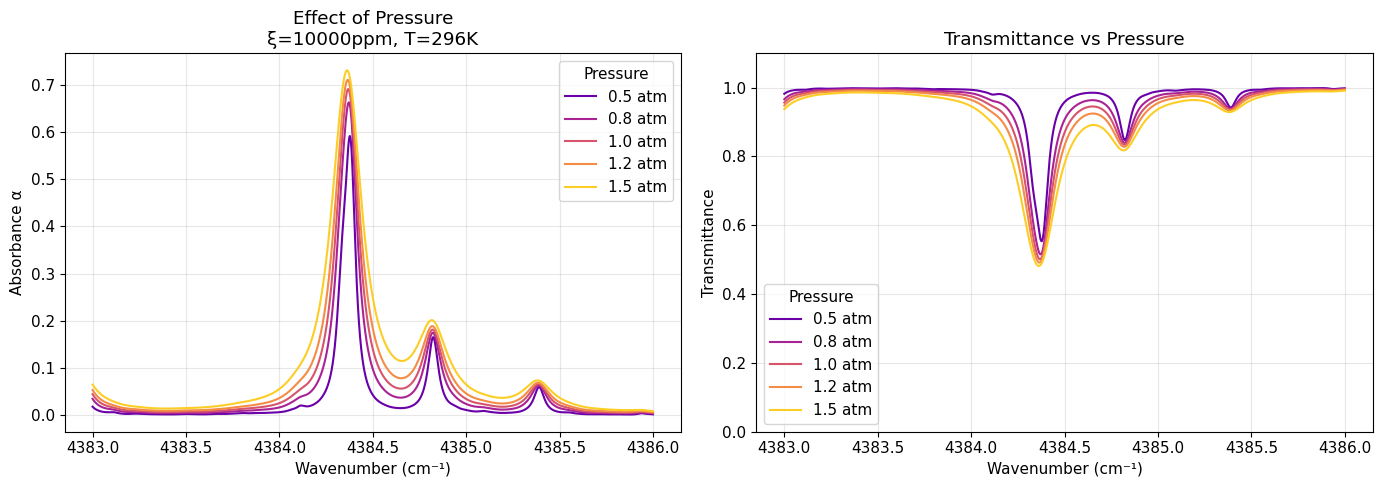

Key observations:
,• Line WIDTH increases with pressure (pressure broadening)
,• Peak HEIGHT decreases as lines broaden (area is conserved)
,• Lines may overlap more at higher pressures
,• This is why the CNN needs to know about pressure.


In [27]:
# Vary pressure
xi_fixed = 0.01  # 10,000 ppm
T_fixed = 296  # K
L = 100  # cm

P_values = [0.5, 0.8, 1.0, 1.2, 1.5]  # atm
P_labels = [f'{P} atm' for P in P_values]
colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(P_values)))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for P, label, color in zip(P_values, P_labels, colors):
    nu, absorbance = generate_absorbance_spectrum(T_fixed, P, xi_fixed, L)
    transmittance = np.exp(-absorbance)
    
    axes[0].plot(nu, absorbance, color=color, linewidth=1.5, label=label)
    axes[1].plot(nu, transmittance, color=color, linewidth=1.5, label=label)

axes[0].set_xlabel('Wavenumber (cm⁻¹)')
axes[0].set_ylabel('Absorbance α')
axes[0].set_title(f'Effect of Pressure\nξ={xi_fixed*1e6:.0f}ppm, T={T_fixed}K')
axes[0].legend(title='Pressure')
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Wavenumber (cm⁻¹)')
axes[1].set_ylabel('Transmittance')
axes[1].set_title('Transmittance vs Pressure')
axes[1].legend(title='Pressure')
axes[1].set_ylim(0, 1.1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key observations:")
print("• Line WIDTH increases with pressure (pressure broadening)")
print("• Peak HEIGHT decreases as lines broaden (area is conserved)")
print("• Lines may overlap more at higher pressures")
print("• This is why the CNN needs to know about pressure.")

---
## 3.5 — Creating a Reusable Spectrum Generator

Let's wrap everything into a clean, reusable class that we'll use for dataset generation.

In [28]:
class CH4SpectrumGenerator:
    """
    Generates CH4 absorbance spectra using HITRAN data.
    
    This class encapsulates all the HITRAN/HAPI setup and provides
    a clean interface for generating spectra at various conditions.
    """
    
    def __init__(self, 
                 nu_min=4383.0, 
                 nu_max=4386.0, 
                 nu_step=0.001,
                 path_length=100.0,
                 data_dir=None):
        """
        Initialize the spectrum generator.
        
        Parameters:
        -----------
        nu_min, nu_max : float
            Wavenumber range in cm⁻¹
        nu_step : float
            Wavenumber resolution in cm⁻¹
        path_length : float
            Optical path length in cm
        data_dir : str
            Directory for HITRAN data cache
        """
        self.nu_min = nu_min
        self.nu_max = nu_max
        self.nu_step = nu_step
        self.path_length = path_length
        self.data_dir = Path(data_dir) if data_dir else Path.home() / 'methane-ml-course' / 'data' / 'hitran'
        
        # HITRAN parameters for CH4
        self.molecule_id = 6
        self.isotope_id = 1
        self.table_name = 'CH4_spectrum'
        
        # Initialize HAPI
        self._setup_hitran()
        
        # Pre-compute wavenumber grid
        self.nu_grid = np.arange(nu_min, nu_max + nu_step, nu_step)
        self.n_points = len(self.nu_grid)
        
        print(f"CH4SpectrumGenerator initialized:")
        print(f"  Wavenumber range: {nu_min} - {nu_max} cm⁻¹")
        print(f"  Resolution: {nu_step} cm⁻¹ ({self.n_points} points)")
        print(f"  Path length: {path_length} cm")
    
    def _setup_hitran(self):
        """Initialize HITRAN database and fetch CH4 data."""
        self.data_dir.mkdir(parents=True, exist_ok=True)
        hapi.db_begin(str(self.data_dir))
        
        # Fetch data if not already cached
        try:
            hapi.fetch(
                TableName=self.table_name,
                M=self.molecule_id,
                I=self.isotope_id,
                numin=self.nu_min,
                numax=self.nu_max
            )
        except:
            pass  # Data already exists
    
    def generate(self, T, P, xi):
        """
        Generate an absorbance spectrum.
        
        Parameters:
        -----------
        T : float
            Temperature in Kelvin
        P : float
            Pressure in atmospheres
        xi : float
            Mole fraction (e.g., 0.01 = 10,000 ppm)
            
        Returns:
        --------
        nu : numpy array
            Wavenumber grid (cm⁻¹)
        absorbance : numpy array
            Absorbance values
        """
        nu, coef = hapi.absorptionCoefficient_Voigt(
            SourceTables=self.table_name,
            Components=[(self.molecule_id, self.isotope_id, xi)],
            Environment={'T': T, 'p': P},
            WavenumberRange=[self.nu_min, self.nu_max],
            WavenumberStep=self.nu_step,
            HITRAN_units=False
        )
        
        absorbance = coef * self.path_length
        return nu, absorbance
    
    def generate_batch(self, conditions):
        """
        Generate multiple spectra.
        
        Parameters:
        -----------
        conditions : list of tuples
            Each tuple is (T, P, xi)
            
        Returns:
        --------
        spectra : numpy array
            Shape (n_conditions, n_points)
        """
        spectra = np.zeros((len(conditions), self.n_points))
        
        for i, (T, P, xi) in enumerate(conditions):
            _, absorbance = self.generate(T, P, xi)
            spectra[i] = absorbance
            
        return spectra
    
    def get_transmittance(self, absorbance):
        """Convert absorbance to transmittance."""
        return np.exp(-absorbance)
    
    def xi_to_ppm(self, xi):
        """Convert mole fraction to ppm."""
        return xi * 1e6
    
    def ppm_to_xi(self, ppm):
        """Convert ppm to mole fraction."""
        return ppm / 1e6

In [29]:
# Test the generator class
generator = CH4SpectrumGenerator(
    nu_min=4383.0,
    nu_max=4386.0,
    nu_step=0.001,
    path_length=100.0
)

Using /root/methane-ml-course/data/hitran
,
,CH4_4383_4386
,                     Lines parsed: 501
,
,Data is fetched from http://hitran.org
,
,BEGIN DOWNLOAD: CH4_spectrum
,  65536 bytes written to /root/methane-ml-course/data/hitran/CH4_spectrum.data
,Header written to /root/methane-ml-course/data/hitran/CH4_spectrum.header
,END DOWNLOAD
,                     Lines parsed: 379
,PROCESSED
,CH4SpectrumGenerator initialized:
,  Wavenumber range: 4383.0 - 4386.0 cm⁻¹
,  Resolution: 0.001 cm⁻¹ (3002 points)
,  Path length: 100.0 cm


{'air': 1.0}
,0.133949 seconds elapsed for abscoef; nlines = 379


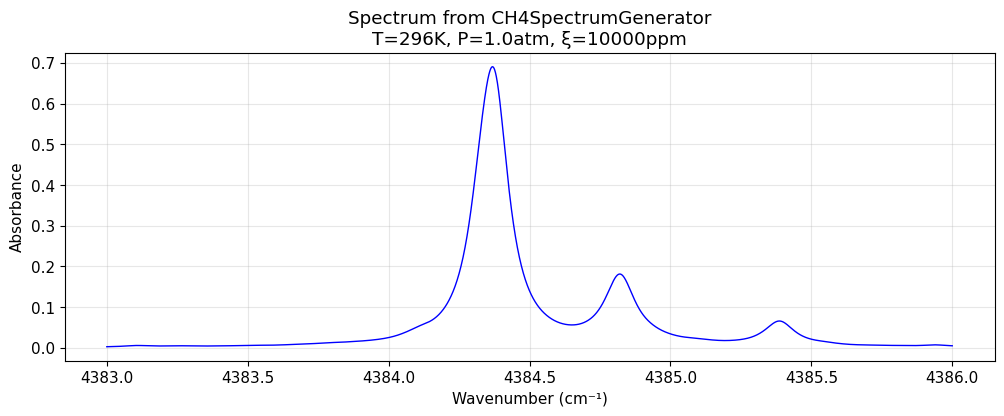

✅ Generator working! Generated 3001 points.


In [30]:
# Generate a spectrum using the class
T, P, xi = 296, 1.0, 0.01
nu, absorbance = generator.generate(T, P, xi)

plt.figure(figsize=(12, 4))
plt.plot(nu, absorbance, 'b-', linewidth=1)
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Absorbance')
plt.title(f'Spectrum from CH4SpectrumGenerator\nT={T}K, P={P}atm, \\chi={generator.xi_to_ppm(xi):.0f}ppm')
plt.grid(True, alpha=0.3)
plt.show()

print(f"✅ Generator working! Generated {len(nu)} points.")

---
## 3.6 — Saving Spectra to Files

For the course, we'll save individual spectra with a descriptive filename convention.

In [31]:
def save_spectrum_csv(nu, absorbance, T, P, L, xi_ppm, output_dir):
    """
    Save spectrum to CSV with standardized filename.
    
    Filename format: TTT-P_P-LLLL-XXXXX.csv
    - TTT: Temperature in K (3 digits)
    - P_P: Pressure in atm (decimal as underscore)
    - LLLL: Path length in cm (4 digits)
    - XXXXX: Mole fraction in ppm (5 digits)
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Create filename
    P_str = f"{P:.1f}".replace('.', '_')
    filename = f"{int(T):03d}-{P_str}-{int(L):04d}-{int(xi_ppm):05d}.csv"
    filepath = output_dir / filename
    
    # Save data
    data = np.column_stack([nu, absorbance])
    header = f"# CH4 Absorbance Spectrum\n# T={T}K, P={P}atm, L={L}cm, xi={xi_ppm}ppm\n# wavenumber(cm-1),absorbance"
    np.savetxt(filepath, data, delimiter=',', header=header, comments='')
    
    return filepath

# Test saving
output_dir = Path.home() / 'methane-ml-course' / 'data' / 'spectra'
filepath = save_spectrum_csv(nu, absorbance, T=296, P=1.0, L=100, xi_ppm=10000, output_dir=output_dir)
print(f"Saved spectrum to: {filepath}")

# Verify by loading
loaded = np.loadtxt(filepath, delimiter=',', skiprows=3)
print(f"Loaded shape: {loaded.shape}")

Saved spectrum to: /root/methane-ml-course/data/spectra/296-1_0-0100-10000.csv
,Loaded shape: (3001, 2)


---
## 3.7 — Interactive Exploration

Let's create an interactive visualization to explore the parameter space.

,LOW concentration (1000 ppm)
,============================================================
,{'air': 1.0}
,0.138719 seconds elapsed for abscoef; nlines = 379


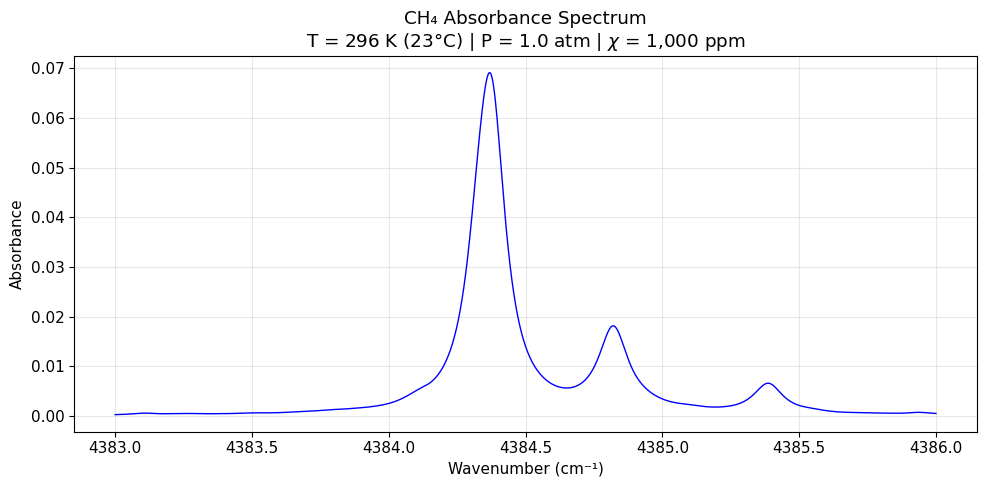

Peak absorbance: 0.0691


In [34]:
def interactive_spectrum_plot(T=296, P=1.0, xi_ppm=10000):
    """
    Generate and plot an absorbance spectrum with given parameters.
    """
    xi = xi_ppm / 1e6
    nu, absorbance = generator.generate(T, P, xi)
    
    plt.figure(figsize=(10, 5))
    plt.plot(nu, absorbance, 'b-', linewidth=1)
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Absorbance')
    plt.title(f'CH₄ Absorbance Spectrum\nT = {T} K ({T-273:.0f}°C) | P = {P} atm | $\\chi$ = {xi_ppm:,} ppm')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Peak absorbance: {absorbance.max():.4f}")

# Try different conditions
print("=" * 60)
print("LOW concentration (1000 ppm)")
print("=" * 60)
interactive_spectrum_plot(T=296, P=1.0, xi_ppm=1000)

,HIGH concentration (50000 ppm = 5%)
,============================================================
,{'air': 1.0}
,0.136323 seconds elapsed for abscoef; nlines = 379


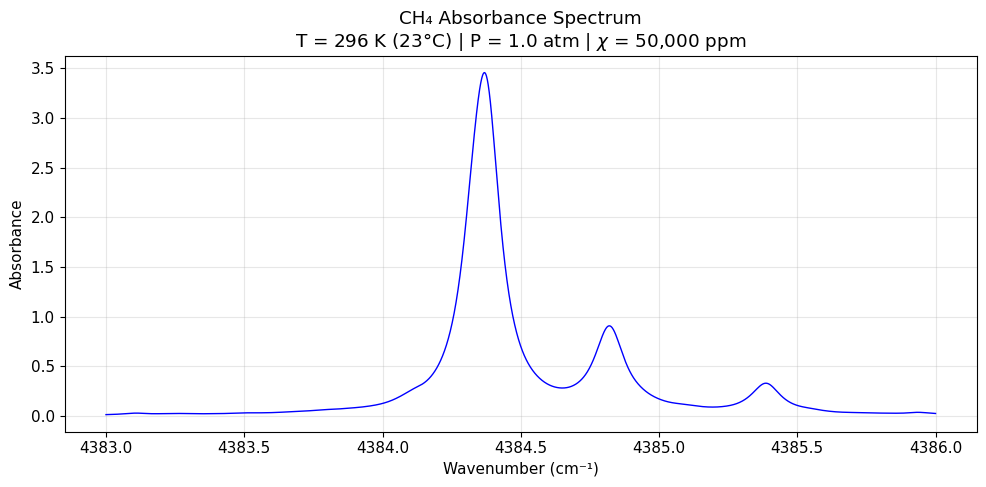

Peak absorbance: 3.4544


In [35]:
print("=" * 60)
print("HIGH concentration (50000 ppm = 5%)")
print("=" * 60)
interactive_spectrum_plot(T=296, P=1.0, xi_ppm=50000)

,COLD temperature (-20°C)
,============================================================
,{'air': 1.0}
,0.133081 seconds elapsed for abscoef; nlines = 379


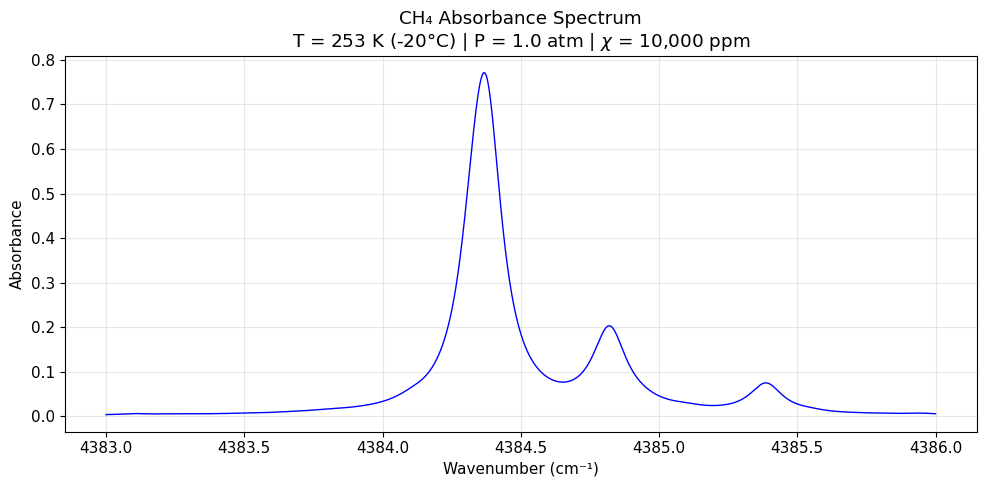

Peak absorbance: 0.7714


In [36]:
print("=" * 60)
print("COLD temperature (-20°C)")
print("=" * 60)
interactive_spectrum_plot(T=253, P=1.0, xi_ppm=10000)

,HIGH pressure (1.2 atm)
,============================================================
,{'air': 1.0}
,0.139563 seconds elapsed for abscoef; nlines = 379


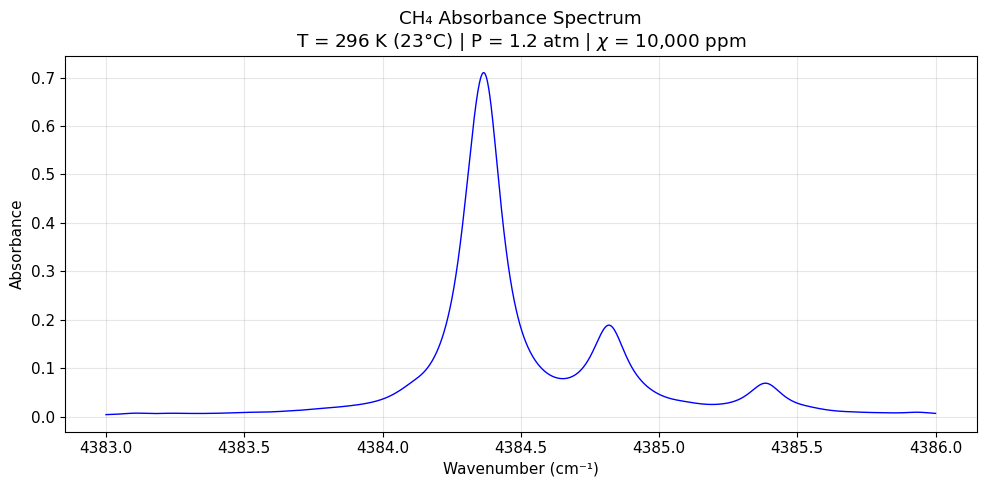

Peak absorbance: 0.7104


In [37]:
print("=" * 60)
print("HIGH pressure (1.2 atm)")
print("=" * 60)
interactive_spectrum_plot(T=296, P=1.2, xi_ppm=10000)

---
## Summary

### What We Accomplished

1. **Installed HAPI** — The official HITRAN Python library
2. **Fetched CH₄ line data** — Downloaded spectroscopic parameters from HITRAN
3. **Generated absorbance spectra** — Using the Voigt line shape with proper T/P dependence
4. **Explored parameter sensitivity** — Saw how T, P, and $\chi$ affect the spectrum
5. **Created a reusable generator class** — Ready for dataset generation

### Key Functions

```python
# Initialize generator
generator = CH4SpectrumGenerator(nu_min=4383, nu_max=4386, nu_step=0.001, path_length=100)

# Generate a spectrum
nu, absorbance = generator.generate(T=296, P=1.0, xi=0.01)

# Convert to transmittance
transmittance = generator.get_transmittance(absorbance)
```

### Key Observations

- **Concentration** → Linear scaling of absorbance (Beer-Lambert)
- **Temperature** → Changes line strength (partition function) and width (Doppler)
- **Pressure** → Changes line width (pressure broadening)
- **Multiple lines** → Provide dynamic range across concentrations

### What's Next

In **Module 4**, we'll simulate the complete detector voltage trace:
- Model the sinusoidal laser drive
- Map voltage to wavenumber over time
- Compute the transmitted intensity $I_t(t)$
- This is what the CNN will actually see!

---
## Exercises

1. **Generate spectra at extreme conditions:**
   - Very low concentration: 100 ppm
   - Very high concentration: 100,000 ppm (10%)
   - What happens to the strongest line at 100,000 ppm?

2. **Explore the line positions:**
   - Use `hapi.getColumns(TABLE_NAME, ['nu', 'sw'])` to get line centers and intensities
   - Which line is strongest? Weakest?

3. **Save multiple spectra:**
   - Generate spectra at T=253K, 273K, 296K, 323K (all at 1 atm, 10000 ppm)
   - Save each to a CSV file
   - Verify the files exist in the output directory

In [ ]:
# Space for exercises

# Exercise 1: Extreme concentrations
# Your code here...

# Exercise 2: Line positions
# Your code here...

# Exercise 3: Save multiple spectra
# Your code here...

---
**Module 3 Complete!**

You can now generate realistic CH₄ absorbance spectra using HITRAN data. In Module 4, we'll add the laser scanning dynamics to create complete detector traces.